# Libraries & Custom functions

In [1]:
import torch
from torchvision.models import resnet18, ResNet18_Weights
import torchvision

import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
# Build a custom CNN composed of 5 convolutional layers with ReLU activation between all the five layers and a fully-connected output layer.

class FashionMNIST_ConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 0)
        self.conv3 = torch.nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 0)
        self.conv4 = torch.nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 0)
        self.conv5 = torch.nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 0)
        self.fc = torch.nn.Linear(512 * 7 * 7, 10)
        self.relu = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.avgpool = torch.nn.AvgPool2d(kernel_size = 2, stride = 2)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.avgpool(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = x.view(-1, 512 * 7 * 7)
        x = self.fc(x)
        return x
    

def set_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')

    elif torch.backends.mps.is_available():
        device = torch.device('mps')

    else:
        device = torch.device('cpu')
    print('Device:', device)

    return device


def train(model, train_loader, test_loader, optimizer, loss_func, epochs, device, **kwargs):
    """
    Trains a neural network model.

    Args:
    - model (torch.nn.Module): The neural network model to be trained.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - optimizer (torch.optim.Optimizer): The optimizer used for training.
    - loss_func (torch.nn.Module): The loss function used for training.
    - epochs (int): Number of training epochs.
    - device (torch.device): The device on which the training will be performed.
    - **kwargs: Additional arguments for customization.

    Returns:
    - train_loss_hist (list): List containing training loss values for each epoch.
    - train_acc_hist (list): List containing training accuracy values for each epoch.
    """

    num_epochs = kwargs.get('num_epochs', epochs)
    loss_fn = kwargs.get('loss_fn', loss_func)
    device = kwargs.get('device', device)

    train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist = [], [], [], []

    # Create a plot with labeled axes
    plt.figure(figsize=(10, 5))
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        print('======== Training phase ========')
        model.train()
        train_loss = 0.
        total = 0.
        correct = 0.
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))

        for batch_idx, (data, target) in pbar:
            data = data.to(device)
            target = target.to(device)
            model.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            pbar.set_description(
                f'Loss = {loss:.4f}  |  Accuracy = {100 * correct / total:.2f}% | Batch ID = {batch_idx + 1} '
            )

        train_loss /= len(train_loader)
        train_accuracy = 100 * correct / total
        print(f'Training Cross-Entropy Loss = {train_loss:.4f}')
        print(f'Training Accuracy = {train_accuracy:.2f}%')

        # Evaluate the model on the validation set
        print('======== Validation phase ========')
        model.eval()
        val_loss = 0.
        total = 0.
        correct = 0.
        pbar = tqdm(enumerate(test_loader), total=len(test_loader))

        for batch_idx, (data, target) in pbar:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss = loss_fn(output, target)

            val_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            pbar.set_description(
                f'Loss = {loss:.4f}  |  Accuracy = {100 * correct / total:.2f}% | Batch ID = {batch_idx + 1} '
            )

        val_loss /= len(test_loader)
        val_accuracy = 100 * correct / total
        print(f'Validation Cross-Entropy Loss = {val_loss:.4f}')
        print(f'Validation Accuracy = {val_accuracy:.2f}%')
        print()

        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_accuracy)
        test_loss_hist.append(val_loss)
        test_acc_hist.append(val_accuracy)


    # Plot the training loss over epochs
    epochs = range(2, len(train_loss_hist) + 1)

    plt.plot(epochs, train_loss_hist[1:], label='Training Loss')
    plt.plot(epochs, test_loss_hist[1:], label='Validation Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Evolution')
    plt.show()

    print(f"Cross-Entropy on training set:  {train_loss_hist[-1]:.4f}")
    print(f"Accuracy on training set:       {train_acc_hist[-1]:.2f}%")
    print()
    print(f"Cross-Entropy on validation set: {test_loss_hist[-1]:.4f}")
    print(f"Accuracy on validation set:      {test_acc_hist[-1]:.2f}%")

    return train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist

# Exercise 1

## Exercise 1 (A)

### Exercise 1 (A) i) - Change the padding from 0 to 1

By changing the padding from zero to one, what happens is that a convolutional layer's input size will be increased by one border, ensuring that the layer's output size will be larger as well, assuming all the remaining hyper-parameters are kept the same. For example, given an image size of 30x30xK, a padding of one can be implemented so that the image's intensity values in its borders get used more that once for making convolution operations, meaning that this border data is used more times than it would be with a padding of 0. This can be crucial because important data might be in the borders, and therefore by applying a padding of 1 we ensure that the data in the borders is used more times to compute the outputs of that convolutional layer. A padding of 1 will increase the size of this given image from 30x30xK to 31x31xK, where this new border will have no importance in terms of its values, however enable the data in the real borders to get used more times. With a padding of 0 a corner will get used once and an edge either 2 (edge point next to a corner) or 3 times, while with a padding of 1 a corner data point will be used 4 times, while the edges will be used 6 times. Looking at the equation that defines the output size given the input size and the hyper-parameters defined, by changing from a padding of 0 to a padding of 1, the output size increases by (...value...).

**ChatGPT's feedback with my writing style...**

Switching the padding from 0 to 1 in a convolutional layer is like giving the edges of your input image a bit more attention. Let's say we've got a cool 30x30xK image. With a padding of 1, we're extending the party by one unit all around, turning it into a 31x31xK extravaganza.

Now, why does this matter? Well, those pixels at the borders get more love during the convolution operation. It's like making sure your image edges are VIPs – they get used more times in the calculation. With padding 0, a corner only gets used once, and an edge (the point next to a corner) gets used 2 or 3 times. But pop in a padding of 1, and suddenly, a corner pixel is the star of the show, getting used a whopping 4 times! As for the edges, they become the popular kids, getting used 6 times.

So, changing the padding to 1 isn't just adding a useless border; it's a strategic move to make sure your model pays extra attention to the edges and corners, where the real action might be happening.

### Exercise 1 (A) ii) - Change the kernel size from 3 to 4

By changingthe kernel size from 3 to 4, what ends up happening is that the output dimensions of the convolutional layer decrease (assuming everything else constant), while the input dimensions stay the same. Notice that by increasing the kernel size by one the number of convolutions applied to an image (for example) gets reduced, and because for each convolution operation one value is computed and added to the output of the layer, then the number of values added to the output is decreased, meaning that the output dimensions will decrease. Looking at the equation that defines the output size, by changing the kernel size from 3 to 4, the output dimensions get increased by (...value...).

**ChatGPT's feedback with my writing style...**

Shifting the kernel size from 3 to 4 in a convolutional layer triggers a slick maneuver – the output dimensions decide to slim down (assuming everything else is on chill mode). Here's the scoop: when we jack up the kernel size by one, it's like telling the layer, 'Hey, ease up on the convolutions, would ya?'

You see, every time we run a convolution operation, we crunch out a value that contributes to the layer's output. Now, with a kernel size of 4, each convolution operation packs a bit more punch. So, naturally, the overall number of these impactful values tossed into the output takes a dip. Less hustle, less bustle, and voila – the output dimensions take a step back.

### Exercise 1 (A) iii) - Change the stride from 1 to 2

By changing the stride from 1 to 2, what ends up happening is that several convolution operations get skipped in a convolutional layer, and because each convolution computes one value of the layer's output, the output's dimensions get decreased, while the input size remains the same. With a stride of 1, what happens is that the kernel moves one column at a time in the same row, and one row at a time in the same column. However, with a stride of 2 the kernel moves two columns at a time in the same row, and two rows at a time in the same column. In short, a convolutional layer with stride of 2 skips half of the convolution operations that would be computed if that convolutional layer had a stride of 1. Looking at the equation that defines the output size, by changing the stride from 1 to 2, the output dimensions get decreased practically in half.

## Exercise 1 (B)

Looking at the following statement: ”Pooling layers introduce a trade-off between information loss and dimensionality reduction”, we can say that is summarizes correctly the role that a Pooling layer has in a convolutional neural network. A pooling layer shares one main idea with a convolutional layer, which is the fact that it reduces the size of the input by applying a kernel to it. However, a pooling layer is much different that a convolutional layer because of two main factors. Firstly, the kernel in a pooling layers doesn't apply convolution operation to the input; a pooling layer can apply either a maximum operation, an average operation, or a minimum operation (althouth the first two are more used given they show better results). Secondly, a pooling layer doesn't have any trainable parameters (or parameters even), while a convolutional layer has. This second difference is very crucial because we're able to simplify out problem by reducing the size of the data without increase the model's complexity (number of trainable parameters). Now, making our ConvNets lighter by reduncing the data's dimensions comes with a cost... Because we're reducing the size of the data given to a pooling layer, what happens is that we lose information by filtering some data out. For example, a MaxPooling layer with a kernel size of 2 retrieves only one value from a region with four values (2x2 square in the input), and this is applied to all the data points given to the model (images for example). Usually a pooling layer with a kernel size of 2 is also used with a stride of 2, and this means that we reduce the input data by exactly half, and filters out 75% of all the data values for each data point. So, going back to the initial statement... It's true that we lose information by applying a pooling layer (regardless of what type), however we have the trade-off of reducing our data's dimensions, so that the models don't need as much computations to fit to the data while also not adding a single trainable parameter to the ConvNet.

## Exercise 1 (C)

In [16]:
# Define data preprocessing and loading / Define a transform to convert to images to tensor and normalize
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.FashionMNIST(root = './data', train = True, transform = transform, download = True)
test_dataset = torchvision.datasets.FashionMNIST(root = './data', train = False, transform = transform, download = True)

batch_size = 256

TrainLoader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
TestLoader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

### Exercise 1 (C) i)

In [19]:
# Initialize the network, loss function, and optimizer
device = set_device()
ConvNet = FashionMNIST_ConvNet().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ConvNet.parameters(), lr = 0.01)

Device: mps


Epoch 1/24
======== Training phase ========


Loss = 0.4352  |  Accuracy = 72.71% | Batch ID = 235 : 100%|██████████| 235/235 [00:13<00:00, 17.37it/s]


Training Cross-Entropy Loss = 1.6469
Training Accuracy = 72.71%
======== Validation phase ========


Loss = 0.4233  |  Accuracy = 81.66% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 34.22it/s]


Validation Cross-Entropy Loss = 0.4927
Validation Accuracy = 81.66%

Epoch 2/24
======== Training phase ========


Loss = 0.2952  |  Accuracy = 84.55% | Batch ID = 235 : 100%|██████████| 235/235 [00:13<00:00, 17.83it/s]


Training Cross-Entropy Loss = 0.4175
Training Accuracy = 84.55%
======== Validation phase ========


Loss = 0.2271  |  Accuracy = 85.91% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 38.10it/s]


Validation Cross-Entropy Loss = 0.3783
Validation Accuracy = 85.91%

Epoch 3/24
======== Training phase ========


Loss = 0.2742  |  Accuracy = 87.03% | Batch ID = 235 : 100%|██████████| 235/235 [00:13<00:00, 17.84it/s]


Training Cross-Entropy Loss = 0.3527
Training Accuracy = 87.03%
======== Validation phase ========


Loss = 0.2289  |  Accuracy = 86.90% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 37.65it/s]


Validation Cross-Entropy Loss = 0.3532
Validation Accuracy = 86.90%

Epoch 4/24
======== Training phase ========


Loss = 0.3053  |  Accuracy = 87.99% | Batch ID = 235 : 100%|██████████| 235/235 [00:13<00:00, 17.84it/s]


Training Cross-Entropy Loss = 0.3270
Training Accuracy = 87.99%
======== Validation phase ========


Loss = 0.2256  |  Accuracy = 87.16% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 37.96it/s]


Validation Cross-Entropy Loss = 0.3352
Validation Accuracy = 87.16%

Epoch 5/24
======== Training phase ========


Loss = 0.3859  |  Accuracy = 88.61% | Batch ID = 235 : 100%|██████████| 235/235 [00:13<00:00, 17.90it/s]


Training Cross-Entropy Loss = 0.3099
Training Accuracy = 88.61%
======== Validation phase ========


Loss = 0.3975  |  Accuracy = 88.24% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 38.33it/s]


Validation Cross-Entropy Loss = 0.3238
Validation Accuracy = 88.24%

Epoch 6/24
======== Training phase ========


Loss = 0.2444  |  Accuracy = 89.41% | Batch ID = 235 : 100%|██████████| 235/235 [00:13<00:00, 17.90it/s]


Training Cross-Entropy Loss = 0.2895
Training Accuracy = 89.41%
======== Validation phase ========


Loss = 0.1871  |  Accuracy = 88.71% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 37.51it/s]


Validation Cross-Entropy Loss = 0.3152
Validation Accuracy = 88.71%

Epoch 7/24
======== Training phase ========


Loss = 0.3553  |  Accuracy = 89.76% | Batch ID = 235 : 100%|██████████| 235/235 [00:13<00:00, 17.87it/s]


Training Cross-Entropy Loss = 0.2752
Training Accuracy = 89.76%
======== Validation phase ========


Loss = 0.1612  |  Accuracy = 89.06% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 37.22it/s]


Validation Cross-Entropy Loss = 0.3018
Validation Accuracy = 89.06%

Epoch 8/24
======== Training phase ========


Loss = 0.2782  |  Accuracy = 90.04% | Batch ID = 235 : 100%|██████████| 235/235 [00:13<00:00, 17.88it/s]


Training Cross-Entropy Loss = 0.2709
Training Accuracy = 90.04%
======== Validation phase ========


Loss = 0.0809  |  Accuracy = 88.86% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 37.62it/s]


Validation Cross-Entropy Loss = 0.3020
Validation Accuracy = 88.86%

Epoch 9/24
======== Training phase ========


Loss = 0.2397  |  Accuracy = 90.06% | Batch ID = 235 : 100%|██████████| 235/235 [00:13<00:00, 17.85it/s]


Training Cross-Entropy Loss = 0.2700
Training Accuracy = 90.06%
======== Validation phase ========


Loss = 0.1773  |  Accuracy = 88.81% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 35.97it/s]


Validation Cross-Entropy Loss = 0.3020
Validation Accuracy = 88.81%

Epoch 10/24
======== Training phase ========


Loss = 0.2524  |  Accuracy = 90.43% | Batch ID = 235 : 100%|██████████| 235/235 [00:13<00:00, 17.86it/s]


Training Cross-Entropy Loss = 0.2586
Training Accuracy = 90.43%
======== Validation phase ========


Loss = 0.1283  |  Accuracy = 88.13% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 37.33it/s]


Validation Cross-Entropy Loss = 0.3206
Validation Accuracy = 88.13%

Epoch 11/24
======== Training phase ========


Loss = 0.1867  |  Accuracy = 90.44% | Batch ID = 235 : 100%|██████████| 235/235 [00:13<00:00, 17.86it/s]


Training Cross-Entropy Loss = 0.2549
Training Accuracy = 90.44%
======== Validation phase ========


Loss = 0.0979  |  Accuracy = 87.98% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 36.89it/s]


Validation Cross-Entropy Loss = 0.3244
Validation Accuracy = 87.98%

Epoch 12/24
======== Training phase ========


Loss = 0.4338  |  Accuracy = 91.09% | Batch ID = 235 : 100%|██████████| 235/235 [00:13<00:00, 17.91it/s]


Training Cross-Entropy Loss = 0.2430
Training Accuracy = 91.09%
======== Validation phase ========


Loss = 0.1510  |  Accuracy = 88.93% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 37.63it/s]


Validation Cross-Entropy Loss = 0.3224
Validation Accuracy = 88.93%

Epoch 13/24
======== Training phase ========


Loss = 0.2425  |  Accuracy = 89.94% | Batch ID = 235 : 100%|██████████| 235/235 [00:13<00:00, 17.87it/s]


Training Cross-Entropy Loss = 0.2764
Training Accuracy = 89.94%
======== Validation phase ========


Loss = 0.1581  |  Accuracy = 88.94% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 37.46it/s]


Validation Cross-Entropy Loss = 0.3158
Validation Accuracy = 88.94%

Epoch 14/24
======== Training phase ========


Loss = 0.3863  |  Accuracy = 91.23% | Batch ID = 235 : 100%|██████████| 235/235 [00:13<00:00, 17.93it/s]


Training Cross-Entropy Loss = 0.2375
Training Accuracy = 91.23%
======== Validation phase ========


Loss = 0.0834  |  Accuracy = 88.76% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 37.58it/s]


Validation Cross-Entropy Loss = 0.3077
Validation Accuracy = 88.76%

Epoch 15/24
======== Training phase ========


Loss = 0.1695  |  Accuracy = 91.24% | Batch ID = 235 : 100%|██████████| 235/235 [00:13<00:00, 17.83it/s]


Training Cross-Entropy Loss = 0.2338
Training Accuracy = 91.24%
======== Validation phase ========


Loss = 0.0789  |  Accuracy = 89.29% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 33.46it/s]


Validation Cross-Entropy Loss = 0.3015
Validation Accuracy = 89.29%

Epoch 16/24
======== Training phase ========


Loss = 0.2296  |  Accuracy = 91.25% | Batch ID = 235 : 100%|██████████| 235/235 [00:13<00:00, 17.65it/s]


Training Cross-Entropy Loss = 0.2287
Training Accuracy = 91.25%
======== Validation phase ========


Loss = 0.0596  |  Accuracy = 88.94% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 37.89it/s]


Validation Cross-Entropy Loss = 0.3085
Validation Accuracy = 88.94%

Epoch 17/24
======== Training phase ========


Loss = 0.3699  |  Accuracy = 91.48% | Batch ID = 235 : 100%|██████████| 235/235 [00:13<00:00, 17.79it/s]


Training Cross-Entropy Loss = 0.2308
Training Accuracy = 91.48%
======== Validation phase ========


Loss = 0.0607  |  Accuracy = 88.74% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 35.02it/s]


Validation Cross-Entropy Loss = 0.3611
Validation Accuracy = 88.74%

Epoch 18/24
======== Training phase ========


Loss = 0.2630  |  Accuracy = 91.53% | Batch ID = 235 : 100%|██████████| 235/235 [00:13<00:00, 17.85it/s]


Training Cross-Entropy Loss = 0.2259
Training Accuracy = 91.53%
======== Validation phase ========


Loss = 0.0542  |  Accuracy = 88.32% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 36.28it/s]


Validation Cross-Entropy Loss = 0.3567
Validation Accuracy = 88.32%

Epoch 19/24
======== Training phase ========


Loss = 0.2603  |  Accuracy = 91.60% | Batch ID = 235 : 100%|██████████| 235/235 [00:13<00:00, 17.85it/s]


Training Cross-Entropy Loss = 0.2252
Training Accuracy = 91.60%
======== Validation phase ========


Loss = 0.5242  |  Accuracy = 88.08% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 36.89it/s]


Validation Cross-Entropy Loss = 0.3440
Validation Accuracy = 88.08%

Epoch 20/24
======== Training phase ========


Loss = 0.1925  |  Accuracy = 91.43% | Batch ID = 235 : 100%|██████████| 235/235 [00:13<00:00, 17.88it/s]


Training Cross-Entropy Loss = 0.2240
Training Accuracy = 91.43%
======== Validation phase ========


Loss = 0.0838  |  Accuracy = 88.85% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 35.67it/s]


Validation Cross-Entropy Loss = 0.3274
Validation Accuracy = 88.85%

Epoch 21/24
======== Training phase ========


Loss = 0.2050  |  Accuracy = 91.83% | Batch ID = 235 : 100%|██████████| 235/235 [00:13<00:00, 17.74it/s]


Training Cross-Entropy Loss = 0.2158
Training Accuracy = 91.83%
======== Validation phase ========


Loss = 0.2394  |  Accuracy = 88.96% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 34.26it/s]


Validation Cross-Entropy Loss = 0.3304
Validation Accuracy = 88.96%

Epoch 22/24
======== Training phase ========


Loss = 0.3263  |  Accuracy = 92.09% | Batch ID = 235 : 100%|██████████| 235/235 [00:13<00:00, 17.85it/s]


Training Cross-Entropy Loss = 0.2141
Training Accuracy = 92.09%
======== Validation phase ========


Loss = 0.3520  |  Accuracy = 88.11% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 36.07it/s]


Validation Cross-Entropy Loss = 0.3632
Validation Accuracy = 88.11%

Epoch 23/24
======== Training phase ========


Loss = 0.0752  |  Accuracy = 92.04% | Batch ID = 235 : 100%|██████████| 235/235 [00:13<00:00, 17.86it/s]


Training Cross-Entropy Loss = 0.2098
Training Accuracy = 92.04%
======== Validation phase ========


Loss = 0.0835  |  Accuracy = 88.64% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 34.19it/s]


Validation Cross-Entropy Loss = 0.3373
Validation Accuracy = 88.64%

Epoch 24/24
======== Training phase ========


Loss = 0.2307  |  Accuracy = 92.16% | Batch ID = 235 : 100%|██████████| 235/235 [00:13<00:00, 17.87it/s]


Training Cross-Entropy Loss = 0.2079
Training Accuracy = 92.16%
======== Validation phase ========


Loss = 1.2625  |  Accuracy = 88.09% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 36.79it/s]


Validation Cross-Entropy Loss = 0.3960
Validation Accuracy = 88.09%



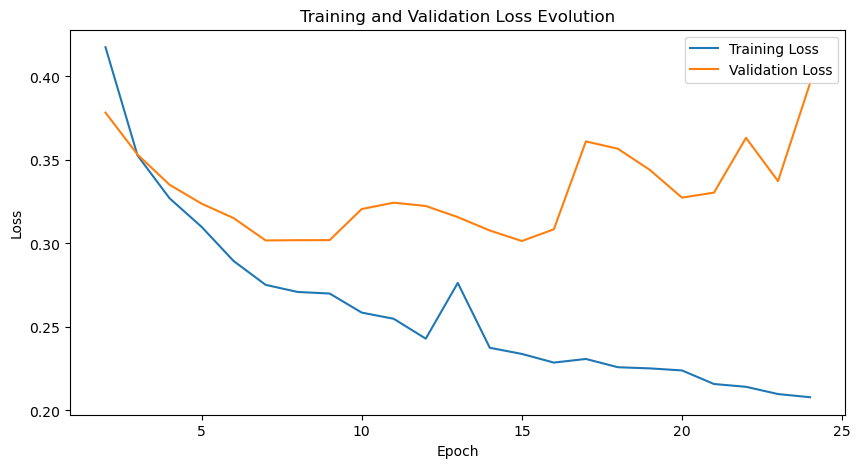

Cross-Entropy on training set:  0.2079
Accuracy on training set:       92.16%

Cross-Entropy on validation set: 0.3960
Accuracy on validation set:      88.09%


In [20]:
train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist = train(ConvNet, TrainLoader, TestLoader, optimizer, criterion, epochs = 24, device = device)

### Exercise 1 (C) ii)

In [21]:
# Use a ResNet-18 without pre-trained weights
ResNet18 = resnet18(weights = None)

# Adapt the ResNet-18 to the FashionMNIST dataset
ResNet18.conv1 = torch.nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3, bias = False)
ResNet18.fc = torch.nn.Linear(ResNet18.fc.in_features, 10)

In [24]:
# Initialize the network, loss function, and optimizer
device = set_device()
ResNet18 = ResNet18.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ResNet18.parameters(), lr = 0.01)

Device: mps


Epoch 1/24
======== Training phase ========


Loss = 0.3504  |  Accuracy = 77.94% | Batch ID = 235 : 100%|██████████| 235/235 [00:18<00:00, 12.81it/s]


Training Cross-Entropy Loss = 0.6350
Training Accuracy = 77.94%
======== Validation phase ========


Loss = 0.4780  |  Accuracy = 82.41% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 24.99it/s]


Validation Cross-Entropy Loss = 0.5045
Validation Accuracy = 82.41%

Epoch 2/24
======== Training phase ========


Loss = 0.1776  |  Accuracy = 87.12% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 15.88it/s]


Training Cross-Entropy Loss = 0.3493
Training Accuracy = 87.12%
======== Validation phase ========


Loss = 0.2906  |  Accuracy = 86.77% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 33.62it/s]


Validation Cross-Entropy Loss = 0.3518
Validation Accuracy = 86.77%

Epoch 3/24
======== Training phase ========


Loss = 0.2270  |  Accuracy = 89.03% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 15.89it/s]


Training Cross-Entropy Loss = 0.2959
Training Accuracy = 89.03%
======== Validation phase ========


Loss = 0.2960  |  Accuracy = 87.81% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 33.47it/s]


Validation Cross-Entropy Loss = 0.3340
Validation Accuracy = 87.81%

Epoch 4/24
======== Training phase ========


Loss = 0.1971  |  Accuracy = 90.23% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 16.01it/s]


Training Cross-Entropy Loss = 0.2616
Training Accuracy = 90.23%
======== Validation phase ========


Loss = 0.1970  |  Accuracy = 88.19% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 34.65it/s]


Validation Cross-Entropy Loss = 0.3456
Validation Accuracy = 88.19%

Epoch 5/24
======== Training phase ========


Loss = 0.3014  |  Accuracy = 90.93% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 16.14it/s]


Training Cross-Entropy Loss = 0.2472
Training Accuracy = 90.93%
======== Validation phase ========


Loss = 0.1403  |  Accuracy = 89.74% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 34.00it/s]


Validation Cross-Entropy Loss = 0.2816
Validation Accuracy = 89.74%

Epoch 6/24
======== Training phase ========


Loss = 0.1019  |  Accuracy = 91.39% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 16.18it/s]


Training Cross-Entropy Loss = 0.2293
Training Accuracy = 91.39%
======== Validation phase ========


Loss = 0.3872  |  Accuracy = 88.86% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 34.14it/s]


Validation Cross-Entropy Loss = 0.3117
Validation Accuracy = 88.86%

Epoch 7/24
======== Training phase ========


Loss = 0.2534  |  Accuracy = 91.98% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 15.93it/s]


Training Cross-Entropy Loss = 0.2124
Training Accuracy = 91.98%
======== Validation phase ========


Loss = 0.1900  |  Accuracy = 88.10% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 33.21it/s]


Validation Cross-Entropy Loss = 0.3284
Validation Accuracy = 88.10%

Epoch 8/24
======== Training phase ========


Loss = 0.2717  |  Accuracy = 92.46% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 16.15it/s]


Training Cross-Entropy Loss = 0.1999
Training Accuracy = 92.46%
======== Validation phase ========


Loss = 0.5900  |  Accuracy = 90.59% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 33.05it/s]


Validation Cross-Entropy Loss = 0.2847
Validation Accuracy = 90.59%

Epoch 9/24
======== Training phase ========


Loss = 0.2508  |  Accuracy = 92.91% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 16.20it/s]


Training Cross-Entropy Loss = 0.1905
Training Accuracy = 92.91%
======== Validation phase ========


Loss = 0.1694  |  Accuracy = 90.09% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 33.36it/s]


Validation Cross-Entropy Loss = 0.2819
Validation Accuracy = 90.09%

Epoch 10/24
======== Training phase ========


Loss = 0.1027  |  Accuracy = 93.23% | Batch ID = 235 : 100%|██████████| 235/235 [00:15<00:00, 15.57it/s]


Training Cross-Entropy Loss = 0.1794
Training Accuracy = 93.23%
======== Validation phase ========


Loss = 0.1083  |  Accuracy = 89.36% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 33.39it/s]


Validation Cross-Entropy Loss = 0.2892
Validation Accuracy = 89.36%

Epoch 11/24
======== Training phase ========


Loss = 0.2634  |  Accuracy = 93.76% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 15.70it/s]


Training Cross-Entropy Loss = 0.1672
Training Accuracy = 93.76%
======== Validation phase ========


Loss = 0.2719  |  Accuracy = 90.34% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 33.28it/s]


Validation Cross-Entropy Loss = 0.2801
Validation Accuracy = 90.34%

Epoch 12/24
======== Training phase ========


Loss = 0.1590  |  Accuracy = 93.85% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 15.91it/s]


Training Cross-Entropy Loss = 0.1615
Training Accuracy = 93.85%
======== Validation phase ========


Loss = 0.3096  |  Accuracy = 90.53% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 33.64it/s]


Validation Cross-Entropy Loss = 0.2772
Validation Accuracy = 90.53%

Epoch 13/24
======== Training phase ========


Loss = 0.1192  |  Accuracy = 94.45% | Batch ID = 235 : 100%|██████████| 235/235 [00:15<00:00, 15.48it/s]


Training Cross-Entropy Loss = 0.1474
Training Accuracy = 94.45%
======== Validation phase ========


Loss = 0.1871  |  Accuracy = 90.87% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 33.19it/s]


Validation Cross-Entropy Loss = 0.2701
Validation Accuracy = 90.87%

Epoch 14/24
======== Training phase ========


Loss = 0.1599  |  Accuracy = 94.81% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 16.10it/s]


Training Cross-Entropy Loss = 0.1371
Training Accuracy = 94.81%
======== Validation phase ========


Loss = 0.6187  |  Accuracy = 90.72% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 33.81it/s]


Validation Cross-Entropy Loss = 0.3004
Validation Accuracy = 90.72%

Epoch 15/24
======== Training phase ========


Loss = 0.1297  |  Accuracy = 95.06% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 16.20it/s]


Training Cross-Entropy Loss = 0.1302
Training Accuracy = 95.06%
======== Validation phase ========


Loss = 0.4503  |  Accuracy = 91.15% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 34.50it/s]


Validation Cross-Entropy Loss = 0.2843
Validation Accuracy = 91.15%

Epoch 16/24
======== Training phase ========


Loss = 0.1007  |  Accuracy = 95.41% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 16.16it/s]


Training Cross-Entropy Loss = 0.1220
Training Accuracy = 95.41%
======== Validation phase ========


Loss = 0.4212  |  Accuracy = 90.39% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 33.26it/s]


Validation Cross-Entropy Loss = 0.3008
Validation Accuracy = 90.39%

Epoch 17/24
======== Training phase ========


Loss = 0.1592  |  Accuracy = 95.68% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 16.09it/s]


Training Cross-Entropy Loss = 0.1120
Training Accuracy = 95.68%
======== Validation phase ========


Loss = 1.0328  |  Accuracy = 90.65% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 33.73it/s]


Validation Cross-Entropy Loss = 0.3248
Validation Accuracy = 90.65%

Epoch 18/24
======== Training phase ========


Loss = 0.1176  |  Accuracy = 95.95% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 16.16it/s]


Training Cross-Entropy Loss = 0.1063
Training Accuracy = 95.95%
======== Validation phase ========


Loss = 0.1517  |  Accuracy = 90.90% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 33.02it/s]


Validation Cross-Entropy Loss = 0.2971
Validation Accuracy = 90.90%

Epoch 19/24
======== Training phase ========


Loss = 0.1412  |  Accuracy = 96.32% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 16.24it/s]


Training Cross-Entropy Loss = 0.0973
Training Accuracy = 96.32%
======== Validation phase ========


Loss = 0.9084  |  Accuracy = 91.03% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 34.12it/s]


Validation Cross-Entropy Loss = 0.3155
Validation Accuracy = 91.03%

Epoch 20/24
======== Training phase ========


Loss = 0.0628  |  Accuracy = 96.78% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 16.29it/s]


Training Cross-Entropy Loss = 0.0857
Training Accuracy = 96.78%
======== Validation phase ========


Loss = 0.7573  |  Accuracy = 91.24% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 34.39it/s]


Validation Cross-Entropy Loss = 0.3366
Validation Accuracy = 91.24%

Epoch 21/24
======== Training phase ========


Loss = 0.0763  |  Accuracy = 96.72% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 16.10it/s]


Training Cross-Entropy Loss = 0.0874
Training Accuracy = 96.72%
======== Validation phase ========


Loss = 0.5914  |  Accuracy = 91.48% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 33.98it/s]


Validation Cross-Entropy Loss = 0.3103
Validation Accuracy = 91.48%

Epoch 22/24
======== Training phase ========


Loss = 0.1026  |  Accuracy = 97.13% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 16.18it/s]


Training Cross-Entropy Loss = 0.0757
Training Accuracy = 97.13%
======== Validation phase ========


Loss = 0.6841  |  Accuracy = 90.78% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 33.11it/s]


Validation Cross-Entropy Loss = 0.3662
Validation Accuracy = 90.78%

Epoch 23/24
======== Training phase ========


Loss = 0.1297  |  Accuracy = 97.19% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 16.27it/s]


Training Cross-Entropy Loss = 0.0753
Training Accuracy = 97.19%
======== Validation phase ========


Loss = 1.0246  |  Accuracy = 91.04% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 34.39it/s]


Validation Cross-Entropy Loss = 0.3638
Validation Accuracy = 91.04%

Epoch 24/24
======== Training phase ========


Loss = 0.0900  |  Accuracy = 97.39% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 16.20it/s]


Training Cross-Entropy Loss = 0.0691
Training Accuracy = 97.39%
======== Validation phase ========


Loss = 0.3702  |  Accuracy = 91.07% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 34.05it/s]


Validation Cross-Entropy Loss = 0.3579
Validation Accuracy = 91.07%



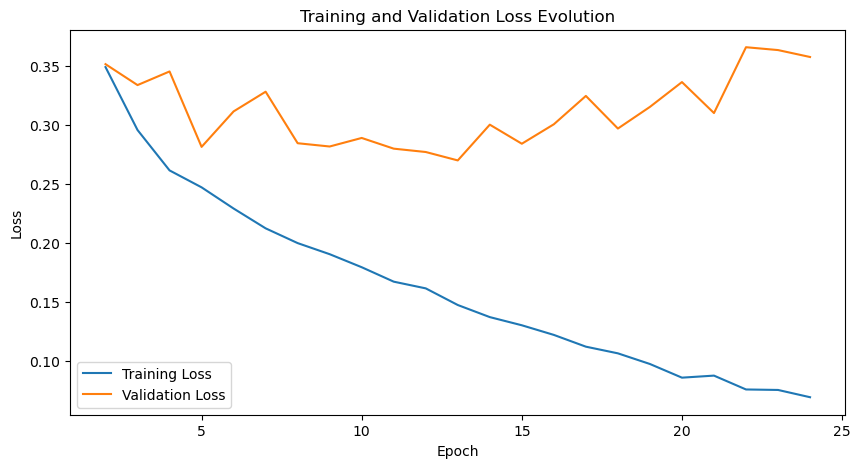

Cross-Entropy on training set:  0.0691
Accuracy on training set:       97.39%

Cross-Entropy on validation set: 0.3579
Accuracy on validation set:      91.07%


In [25]:
# Train the network
train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist = train(ResNet18, TrainLoader, TestLoader, optimizer, criterion, epochs = 24, device = device)

### Exercise 1 (C) iii)

In [32]:
# Use a ResNet-18 with pre-trained weights
ResNet18_pretrained = resnet18(weights = ResNet18_Weights.DEFAULT)

# Adapt the ResNet-18 pre-trained to the FashionMNIST dataset
ResNet18_pretrained.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
ResNet18_pretrained.fc = torch.nn.Linear(ResNet18_pretrained.fc.in_features, 10)

In [33]:
# Initialize the network, loss function, and optimizer
device = set_device()
ResNet18_pretrained = ResNet18_pretrained.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ResNet18_pretrained.parameters(), lr = 0.01)

Device: mps


Epoch 1/24
======== Training phase ========


Loss = 0.3621  |  Accuracy = 76.58% | Batch ID = 235 : 100%|██████████| 235/235 [00:15<00:00, 15.52it/s]


Training Cross-Entropy Loss = 0.6621
Training Accuracy = 76.58%
======== Validation phase ========


Loss = 0.6617  |  Accuracy = 81.95% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 33.79it/s]


Validation Cross-Entropy Loss = 0.5039
Validation Accuracy = 81.95%

Epoch 2/24
======== Training phase ========


Loss = 0.3254  |  Accuracy = 86.05% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 15.78it/s]


Training Cross-Entropy Loss = 0.3821
Training Accuracy = 86.05%
======== Validation phase ========


Loss = 0.3658  |  Accuracy = 79.94% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 33.57it/s]


Validation Cross-Entropy Loss = 0.5601
Validation Accuracy = 79.94%

Epoch 3/24
======== Training phase ========


Loss = 0.2534  |  Accuracy = 88.47% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 16.07it/s]


Training Cross-Entropy Loss = 0.3091
Training Accuracy = 88.47%
======== Validation phase ========


Loss = 0.4114  |  Accuracy = 88.81% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 33.89it/s]


Validation Cross-Entropy Loss = 0.3070
Validation Accuracy = 88.81%

Epoch 4/24
======== Training phase ========


Loss = 0.2736  |  Accuracy = 89.87% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 16.19it/s]


Training Cross-Entropy Loss = 0.2733
Training Accuracy = 89.87%
======== Validation phase ========


Loss = 0.3878  |  Accuracy = 88.62% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 33.59it/s]


Validation Cross-Entropy Loss = 0.3217
Validation Accuracy = 88.62%

Epoch 5/24
======== Training phase ========


Loss = 0.3289  |  Accuracy = 88.85% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 16.17it/s]


Training Cross-Entropy Loss = 0.3049
Training Accuracy = 88.85%
======== Validation phase ========


Loss = 0.2710  |  Accuracy = 88.08% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 33.52it/s]


Validation Cross-Entropy Loss = 0.3198
Validation Accuracy = 88.08%

Epoch 6/24
======== Training phase ========


Loss = 0.3172  |  Accuracy = 90.57% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 16.19it/s]


Training Cross-Entropy Loss = 0.2570
Training Accuracy = 90.57%
======== Validation phase ========


Loss = 0.4161  |  Accuracy = 89.69% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 34.44it/s]


Validation Cross-Entropy Loss = 0.2863
Validation Accuracy = 89.69%

Epoch 7/24
======== Training phase ========


Loss = 0.2103  |  Accuracy = 91.31% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 16.18it/s]


Training Cross-Entropy Loss = 0.2331
Training Accuracy = 91.31%
======== Validation phase ========


Loss = 0.3024  |  Accuracy = 88.91% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 34.58it/s]


Validation Cross-Entropy Loss = 0.2917
Validation Accuracy = 88.91%

Epoch 8/24
======== Training phase ========


Loss = 0.1313  |  Accuracy = 91.98% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 16.25it/s]


Training Cross-Entropy Loss = 0.2148
Training Accuracy = 91.98%
======== Validation phase ========


Loss = 0.5510  |  Accuracy = 89.09% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 34.65it/s]


Validation Cross-Entropy Loss = 0.3118
Validation Accuracy = 89.09%

Epoch 9/24
======== Training phase ========


Loss = 0.2412  |  Accuracy = 92.43% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 16.23it/s]


Training Cross-Entropy Loss = 0.2023
Training Accuracy = 92.43%
======== Validation phase ========


Loss = 0.2552  |  Accuracy = 90.04% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 34.81it/s]


Validation Cross-Entropy Loss = 0.2742
Validation Accuracy = 90.04%

Epoch 10/24
======== Training phase ========


Loss = 0.2461  |  Accuracy = 93.05% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 16.04it/s]


Training Cross-Entropy Loss = 0.1864
Training Accuracy = 93.05%
======== Validation phase ========


Loss = 0.2630  |  Accuracy = 90.16% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 33.88it/s]


Validation Cross-Entropy Loss = 0.2903
Validation Accuracy = 90.16%

Epoch 11/24
======== Training phase ========


Loss = 0.1353  |  Accuracy = 93.22% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 16.09it/s]


Training Cross-Entropy Loss = 0.1783
Training Accuracy = 93.22%
======== Validation phase ========


Loss = 0.4964  |  Accuracy = 90.56% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 34.36it/s]


Validation Cross-Entropy Loss = 0.2798
Validation Accuracy = 90.56%

Epoch 12/24
======== Training phase ========


Loss = 0.2525  |  Accuracy = 93.72% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 16.28it/s]


Training Cross-Entropy Loss = 0.1671
Training Accuracy = 93.72%
======== Validation phase ========


Loss = 0.4794  |  Accuracy = 90.07% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 34.16it/s]


Validation Cross-Entropy Loss = 0.2768
Validation Accuracy = 90.07%

Epoch 13/24
======== Training phase ========


Loss = 0.0934  |  Accuracy = 94.00% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 16.25it/s]


Training Cross-Entropy Loss = 0.1588
Training Accuracy = 94.00%
======== Validation phase ========


Loss = 0.2591  |  Accuracy = 90.17% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 33.74it/s]


Validation Cross-Entropy Loss = 0.2824
Validation Accuracy = 90.17%

Epoch 14/24
======== Training phase ========


Loss = 0.1818  |  Accuracy = 94.33% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 16.19it/s]


Training Cross-Entropy Loss = 0.1489
Training Accuracy = 94.33%
======== Validation phase ========


Loss = 0.3632  |  Accuracy = 91.19% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 33.60it/s]


Validation Cross-Entropy Loss = 0.2600
Validation Accuracy = 91.19%

Epoch 15/24
======== Training phase ========


Loss = 0.1611  |  Accuracy = 94.71% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 15.95it/s]


Training Cross-Entropy Loss = 0.1402
Training Accuracy = 94.71%
======== Validation phase ========


Loss = 1.0030  |  Accuracy = 89.65% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 33.16it/s]


Validation Cross-Entropy Loss = 0.3441
Validation Accuracy = 89.65%

Epoch 16/24
======== Training phase ========


Loss = 0.1395  |  Accuracy = 95.00% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 15.99it/s]


Training Cross-Entropy Loss = 0.1305
Training Accuracy = 95.00%
======== Validation phase ========


Loss = 0.4499  |  Accuracy = 89.62% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 34.46it/s]


Validation Cross-Entropy Loss = 0.3094
Validation Accuracy = 89.62%

Epoch 17/24
======== Training phase ========


Loss = 0.1411  |  Accuracy = 95.38% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 15.99it/s]


Training Cross-Entropy Loss = 0.1241
Training Accuracy = 95.38%
======== Validation phase ========


Loss = 0.8085  |  Accuracy = 90.69% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 34.03it/s]


Validation Cross-Entropy Loss = 0.2879
Validation Accuracy = 90.69%

Epoch 18/24
======== Training phase ========


Loss = 0.1254  |  Accuracy = 95.72% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 15.79it/s]


Training Cross-Entropy Loss = 0.1135
Training Accuracy = 95.72%
======== Validation phase ========


Loss = 0.9160  |  Accuracy = 91.07% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 32.91it/s]


Validation Cross-Entropy Loss = 0.3048
Validation Accuracy = 91.07%

Epoch 19/24
======== Training phase ========


Loss = 0.3546  |  Accuracy = 92.84% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 15.98it/s]


Training Cross-Entropy Loss = 0.2031
Training Accuracy = 92.84%
======== Validation phase ========


Loss = 0.4250  |  Accuracy = 87.20% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 34.29it/s]


Validation Cross-Entropy Loss = 0.3485
Validation Accuracy = 87.20%

Epoch 20/24
======== Training phase ========


Loss = 0.0956  |  Accuracy = 92.41% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 15.99it/s]


Training Cross-Entropy Loss = 0.2030
Training Accuracy = 92.41%
======== Validation phase ========


Loss = 0.8913  |  Accuracy = 89.97% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 34.03it/s]


Validation Cross-Entropy Loss = 0.2884
Validation Accuracy = 89.97%

Epoch 21/24
======== Training phase ========


Loss = 0.1220  |  Accuracy = 94.47% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 16.07it/s]


Training Cross-Entropy Loss = 0.1448
Training Accuracy = 94.47%
======== Validation phase ========


Loss = 0.5085  |  Accuracy = 91.37% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 34.57it/s]


Validation Cross-Entropy Loss = 0.2594
Validation Accuracy = 91.37%

Epoch 22/24
======== Training phase ========


Loss = 0.1738  |  Accuracy = 95.69% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 16.16it/s]


Training Cross-Entropy Loss = 0.1145
Training Accuracy = 95.69%
======== Validation phase ========


Loss = 0.5784  |  Accuracy = 91.27% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 33.99it/s]


Validation Cross-Entropy Loss = 0.2896
Validation Accuracy = 91.27%

Epoch 23/24
======== Training phase ========


Loss = 0.0769  |  Accuracy = 96.19% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 16.08it/s]


Training Cross-Entropy Loss = 0.1004
Training Accuracy = 96.19%
======== Validation phase ========


Loss = 0.5210  |  Accuracy = 90.61% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 34.27it/s]


Validation Cross-Entropy Loss = 0.3337
Validation Accuracy = 90.61%

Epoch 24/24
======== Training phase ========


Loss = 0.0915  |  Accuracy = 96.57% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 16.20it/s]


Training Cross-Entropy Loss = 0.0904
Training Accuracy = 96.57%
======== Validation phase ========


Loss = 0.4613  |  Accuracy = 90.86% | Batch ID = 40 : 100%|██████████| 40/40 [00:01<00:00, 34.82it/s]


Validation Cross-Entropy Loss = 0.3239
Validation Accuracy = 90.86%



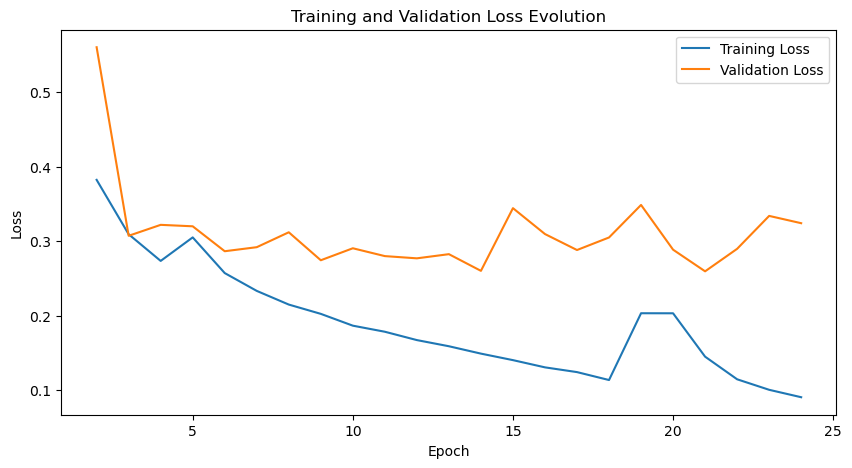

Cross-Entropy on training set:  0.0904
Accuracy on training set:       96.57%

Cross-Entropy on validation set: 0.3239
Accuracy on validation set:      90.86%


In [34]:
# Train the network
train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist = train(ResNet18_pretrained, TrainLoader, TestLoader, optimizer, criterion, epochs = 24, device = device)